# Introduction

The dask library provides parallel versions of many operations available in numpy and pandas. It does this by breaking up an array into chunks.

The full documentation for the Dask library is available at https://docs.dask.org/en/latest/

In [1]:
import dask.array

dask.array.ones((10,10), chunks=(5,5))

dask.array<ones, shape=(10, 10), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

Here I've made a 10x10 array, that's made up of 4 5x5 chunks.

Dask will run operations on different chunks in parallel. It evaluates arrays lazily - data is only computed for the chunks needed, if you don't explicitly load the data (e.g. by using `.compute()`, or plotting or saving the data) it builds up a graph of operations that can be run later when the actual values are needed.

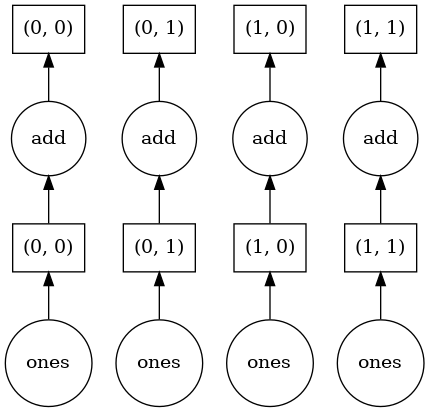

In [2]:
data = dask.array.ones((10,10), chunks=(5,5))

(data + 5).visualize()

In [3]:
(data + 5)[4,6].compute()

6.0

Since I've only asked for a single element of the array, only that one chunk needs to be calculated. This is less important for this tiny example, but it does get important when you've got a huge dataset that you only need a subset of.

## Creating Dask arrays manually

Something to keep in mind with Dask arrays is that you can't directly write to an array element

In [4]:
try:
    data[4, 6] = 3
except Exception as e:
    print('ERROR', e)

ERROR Item assignment with <class 'tuple'> not supported


This keeps us from trying to do calculations with loops, which Dask can't parallelise and are really inefficient in Python. Instead you should use whole-array operations.

Say we want to calculate the area of grid cells, knowing the latitude and longitude of grid point centres.

For each grid point we need to calculate

$$A = R^2\int_{\phi_0}^{\phi_1}\int_{\theta_0}^{\theta_1}\cos\theta d\theta d\phi = R^2(\phi_1 - \phi_0)(\cos \theta_1 - \cos \theta_0)$$

Rather than doing this in a loop over each grid point, we can use numpy array operations, computing the width and height of each cell and then performing an outer vector product to create a 2d array

In [5]:
import numpy
from numpy import deg2rad

# Grid centres
lon = dask.array.linspace(0, 360, num=500, endpoint=False, chunks=100)
lat = dask.array.linspace(-90, 90, num=300, endpoint=True, chunks=100)

# Grid spacing
dlon = (lon[1] - lon[0]).compute()
dlat = (lat[1] - lat[0]).compute()

# Grid edges in radians
lon0 = deg2rad(lon - dlon/2)
lon1 = deg2rad(lon + dlon/2)
lat0 = deg2rad((lat - dlat/2).clip(-90, 90))
lat1 = deg2rad((lat + dlat/2).clip(-90, 90))

# Compute cell dimensions
cell_width = lon1 - lon0
cell_height = numpy.sin(lat1) - numpy.sin(lat0)

# Area
R_earth = 6_371_000
A = R_earth**2 * numpy.outer(cell_height, cell_width)
A

dask.array<mul, shape=(300, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

You can see that even though only numpy operations were used we still ended up with a Dask array at the end. An array much larger than would fit in memory can be created this way, with the values only needing to be computed if they're actually used.

Plotting Dask arrays works just like numpy arrays:

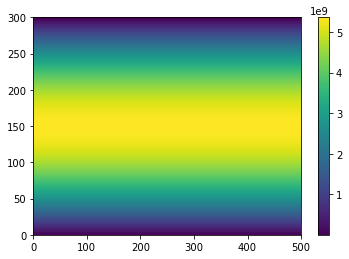

In [6]:
import matplotlib.pyplot as plt
plt.pcolormesh(A)
plt.colorbar()

And we can check the total area is about $5.1 \times 10^{14}$

In [7]:
'%e'%(A.sum().compute())

'5.100645e+14'

## Creating Dask arrays from NetCDF files

The most common way of creating a Dask array is to read them from a netcdf file with Xarray. You can give `open_dataset()` and `open_mfdataset()` a `chunks` parameter, which is how large chunks should be in each dimension of the file.

If you use `open_mfdataset()`, by default each input file will be its own chunk.

In [8]:
import xarray

path = 'https://dapds00.nci.org.au/thredds/dodsC/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc'
ds = xarray.open_dataset(path, chunks={'time': 1})
ds.tas

<xarray.DataArray 'tas' (time: 1980, lat: 144, lon: 192)>
dask.array<open_dataset-0e410aadf9156f5cf0b6cd8c2849d202tas, shape=(1980, 144, 192), dtype=float32, chunksize=(1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-08T06:41:45Z altered by CMOR: Treated scalar dime...
    _ChunkSizes:    [  1 144 192]

There are a few ways to turn a Dask xarray.DataArray back into a numpy array. `.load()` will compute the dask data and retain metadata, `.values` will compute the dask data and return a numpy array, and `.data` will return the dask array itself.

In [9]:
ds.tas[0,50,99].load()

<xarray.DataArray 'tas' ()>
array(295.87695312)
Coordinates:
    time     datetime64[ns] 1850-01-16T12:00:00
    lat      float64 -26.88
    lon      float64 186.6
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-08T06:41:45Z altered by CMOR: Treated scalar dime...
    _ChunkSizes:    [  1 144 192]

In [10]:
ds.tas[0,50,99].values

array(295.87695312)

In [11]:
ds.tas.data

dask.array<open_dataset-0e410aadf9156f5cf0b6cd8c2849d202tas, shape=(1980, 144, 192), dtype=float32, chunksize=(1, 144, 192), chunktype=numpy.ndarray>

## Distributed Dask

Without any special setup, Dask will run operations in threaded mode. You can configure it to run in distributed mode instead with

In [9]:
import dask.distributed
import tempfile

try:
    client
except NameError:
    dask_worker_dir = tempfile.TemporaryDirectory()
    
    client = dask.distributed.Client(
        local_directory = dask_worker_dir.name,
    )
client

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

Client Scheduler: tcp://127.0.0.1:49701 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 17.13 GB


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


This will by default ask for all resources available on your computer.

```{hint}
The `try: ... except NameError:` structure is to make sure only on Dask client is created, in case you execute the notebook cell more than once. If you're writing a python script rather than using a notebook it's not needed.
```

```{warning}
It's important to set the `local_directory` parameter, otherwise Dask will store temporary files in the current working directory which can be a problem if filesystem quotas are enabled.
```

Other useful options are:
 * `n_workers`: Number of distributed processes
 * `threads_per_worker`: Number of shared memory threads within each process
 * `memory_limit`: Memory available to each process (e.g. `'4gb'`)
 
```{warning}
If you're using a shared system, be polite and don't take over the whole system with your Dask cluster, set reasonable limits. If running on NCI's Gadi supercomputer, `climtas.nci.GadiClient()` will inspect the PBS resources requested by `qsub` and set up the cluster using those limits
```

You can follow the dashboard link displayed by Jupyter to get an interactive view of what the Dask cluster is doing.

To stop the Dask cluster run

In [7]:
client.close()

This isn't normally needed, Dask will clean itself up at the end of your script automatically, but it can be helpful if you're experimenting with different cluster sizes.